Get started with required imports:

In [931]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import requests, os, time, lxml

from dotenv import load_dotenv

from bs4 import BeautifulSoup

Load API key from .env and run a sanity check to confirm value is present.

In [932]:
API_KEY = os.getenv("NPS_API_KEY")

print(API_KEY is not None)

True


I'm going to use the dataset to create a dataframe. The data we need is on the second sheet, so I need to specify. I'll also look at the first few rows to make sure this is what I want.

In [933]:
df = pd.ExcelFile(r"../data/NPS-Mortality-Data-CY2007-to-CY2024-Released-August-2024.xlsx")
df = df.parse(sheet_name="CY2007-Present Q2")
df.head()

,Incident Date,Park Name,Cause of Death,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Intent,Outcome,Sex,Age Range,Activity
0,2007-01-01,Glen Canyon National Recreation Area,Undetermined,Undetermined,Undetermined,Fatal injury,Male,65+,Not Reported
1,2007-01-22,Golden Gate National Recreation Area,Drowning,Drowning,Unintentional,Fatal injury,Male,Not Reported,Vessel Related
2,2007-01-22,Golden Gate National Recreation Area,Undetermined,Undetermined,Undetermined,Fatal injury,Male,Not Reported,Vessel Related
3,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Fatal injury,Female,15-24,Driving
4,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Fatal injury,Female,45-54,Driving


Use .info() to get a look at the column names, datatypes, and counts.

In [934]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635 entries, 0 to 4634
Data columns (total 9 columns):
 #   Column                                                        Non-Null Count  Dtype         
---  ------                                                        --------------  -----         
 0   Incident Date                                                 4635 non-null   datetime64[ns]
 1   Park Name                                                     4635 non-null   object        
 2   Cause of Death                                                4635 non-null   object        
 3   Cause of Death Group 
(Used in the NPS Mortality Dashboard)   4635 non-null   object        
 4   Intent                                                        4635 non-null   object        
 5   Outcome                                                       4635 non-null   object        
 6   Sex                                                           4635 non-null   object        
 7   Age Ran

Print a list of the columns that may be easier to reference.

In [935]:
print(df.columns)

Index(['Incident Date', 'Park Name', 'Cause of Death',
       'Cause of Death Group \n(Used in the NPS Mortality Dashboard) ',
       'Intent', 'Outcome', 'Sex', 'Age Range', 'Activity'],
      dtype='object')


I'm going to look more closely at the "Cause of death" and "Cause of Death Group \n..." columns to see if this data is redundant, or if I need to use both in my analysis.

Check if all values in all rows and columns are the same.

In [936]:
(df["Cause of Death"] == df["Cause of Death Group \n(Used in the NPS Mortality Dashboard) "]).all()

np.False_

Since the are not duplicates, I'm going to build a mask to count how many mismatches are in the data.

In [937]:
mask_mismatch = df["Cause of Death"] != df["Cause of Death Group \n(Used in the NPS Mortality Dashboard) "]
print("Total rows:", len(df))
print(mask_mismatch.sum())

Total rows: 4635
494


I'm going to look at some of the mismatches to see what the differences are.

In [938]:
df.loc[mask_mismatch, ["Cause of Death", "Cause of Death Group \n(Used in the NPS Mortality Dashboard) "]].head()

,Cause of Death,Cause of Death Group \n(Used in the NPS Mortality Dashboard)
8,Avalanche,Environmental
9,Vessel Incident,Other Transportation
46,Vessel Incident,Other Transportation
48,Bicycle only crash,Other Transportation
56,Poisoning - Drugs,Poisoning


It seems like I will be able to use the "Cause of Death" column and ignore the group column for now. I'm going to look more closely at the cause of death column now.

In [939]:
df.groupby("Cause of Death").size()

Cause of Death
Aircraft Incident                          31
Aircraft incident                          46
Altitude                                    1
Asphyxiation                                7
Avalanche                                  41
Bicycle only crash                         23
Collapsing earth/sand                       2
Drowning                                  864
Electrocution                               4
Fall                                      505
Falling Ice                                 2
Falling tree/branch                        21
Fire/Burn                                   3
Fire/burn                                   2
Firearm                                     5
Flash flood                                14
Homicide                                   51
Horseback riding Incident                   1
Horseback riding incident                   3
Hyperthermia                               83
Hypothermia                                46
Legal Intervention 

There are some obvious duplicates in that list, so I'm going to normalize the causes to try to catch duplicates. First I'm going to see how many unique values there are now.

In [940]:
df["Cause of Death"].nunique()

48

In [941]:
df["Cause of Death"] = df["Cause of Death"].str.strip().str.lower()

I want to see how many unique values I have now.

In [942]:
df["Cause of Death"].nunique()

42

I'm going to look at a list of the unique values just to see what I have since there aren't that many. I'll sort them in alphabetical order so it will be a little easer to see duplicates.

In [943]:
print(sorted(df["Cause of Death"].unique()))

['aircraft incident', 'altitude', 'asphyxiation', 'avalanche', 'bicycle only crash', 'collapsing earth/sand', 'drowning', 'electrocution', 'fall', 'falling ice', 'falling tree/branch', 'fire/burn', 'firearm', 'flash flood', 'homicide', 'horseback riding incident', 'hyperthermia', 'hypothermia', 'legal intervention', 'lightning strike', 'medical - during physical activity', 'medical - not during physical activity', 'medical - unknown', 'motor vehicle crash', 'other', 'poisoning - alcohol', 'poisoning - carbon monoxide', 'poisoning - drugs', 'poisoning - other', 'rockfall', 'skateboard incident', 'skiing incident', 'snowboard incident', 'snowmobile incident', 'struck by/against', 'suicide', 'train crash', 'trolly crash', 'undetermined', 'vessel incident', 'water diving incident', 'widlife incident']


Looking over the columns, I don't see any duplicates or names that should be changed right now. I'm going to change them back to have an uppercase character.

In [944]:
df["Cause of Death"] = df["Cause of Death"].str.title()
print(df["Cause of Death"])

0              Undetermined
1                  Drowning
2              Undetermined
3       Motor Vehicle Crash
4       Motor Vehicle Crash
               ...         
4630    Motor Vehicle Crash
4631    Motor Vehicle Crash
4632                Suicide
4633           Undetermined
4634           Undetermined
Name: Cause of Death, Length: 4635, dtype: object


Now that I know what column to use and I have eliminated case mismatches, I'm going to build a plot to just look at the causes of death.

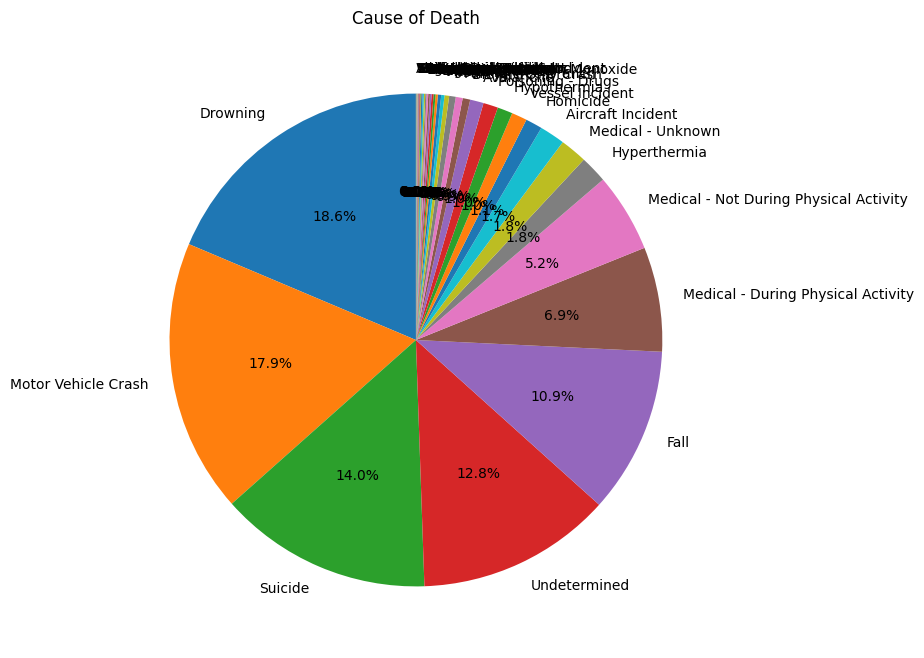

In [945]:
cause_counts = df["Cause of Death"].value_counts()

cause_counts.plot(
    kind="pie",
    autopct="%1.1f%%",
    figsize=(8,8),
    startangle=90
)

plt.ylabel("")
plt.title("Cause of Death")
plt.show()



There are lots of less frequent causes that confuse this plot. I'll do some adjustments to make it more meaningful/easy to read.

I want to show the major causes of death. This will calculate the percentage of deaths attributed to each cause, and also group causes accounting for <5% of deaths be combined into an "other" category to avoid cluttering the plot. The variables defined here will be used in the plot.

In [946]:
cause_counts = df["Cause of Death"].value_counts(dropna=False)
percentages  = cause_counts / cause_counts.sum() * 100

major_causes = percentages[percentages >= 5].copy()
other_total  = percentages[percentages < 5].sum()
if other_total > 0:
    major_causes.loc["Other"] = other_total

I'm going to define my color palette to be used with this plot. I'm also going to set the colors up be the same for both medical cause deaths.

The project’s color palette (hex codes and ordered list) was assisted by ChatGPT to ensure consistent formatting and to streamline selection and presentation.

After generation, I manually verified each hex code and palette entry by comparing them against the reference palette published here:  
<https://siegal.bio.nyu.edu/color-palette/>

No discrepencies were found other than the omission of black, which was intentional to avoid readability issues.

In [947]:
okabe_ito = [
    "#E69F00",
    "#56B4E9",
    "#009E73",
    "#F0E442",
    "#0072B2",
    "#D55E00",
    "#CC79A7", 
]
OTHER_GREY = "#9e9e9e"

def color_for_label(lbl):
    s = str(lbl).strip().lower()
    if s == "other":
        return OTHER_GREY

    if "medical" in s:
        return "#E69F00"  # orange
    return None



Now that the colors are defined, I'll build a for loop to cycle through the unused options.

In [948]:
used = {c for c in [color_for_label(x) for x in major_causes.index] if c}
remaining = [c for c in okabe_ito if c not in used]
colors = []
idx = 0
for lbl in major_causes.index:
    c = color_for_label(lbl)
    if c is None:
        c = remaining[idx % len(remaining)]
        idx += 1
    colors.append(c)

Now I'm going to create a pie chart that shows the major causes of death.

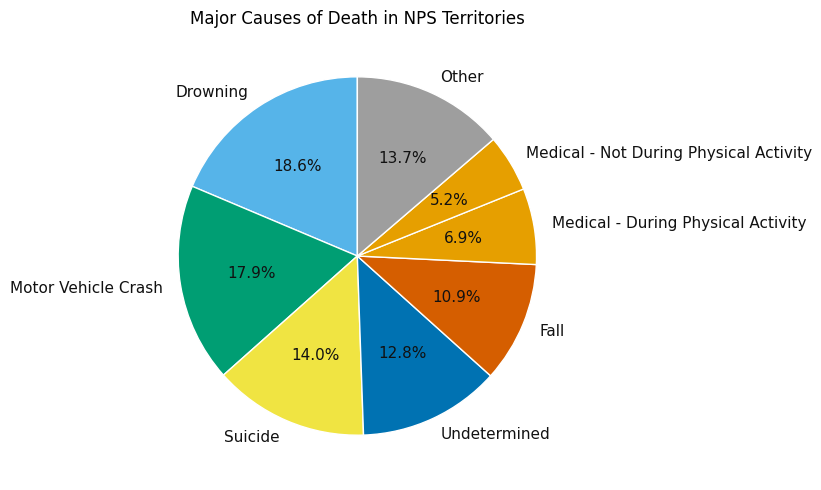

In [949]:
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    major_causes.values,
    labels=major_causes.index,
    colors=colors,
    autopct="%1.1f%%",
    wedgeprops={"linewidth": 1.0, "edgecolor": "white"},
    startangle=90
)
for t in texts:
    t.set_color("#111111")
    t.set_fontsize(11)

for t in autotexts:
    t.set_fontsize(11)
    t.set_color("#111111")
  

ax.set_title("Major Causes of Death in NPS Territories")

plt.tight_layout()
plt.show()


Drowning is the most frequent cause of death, so I'm going to look at that more closely to see if there are any common threads. I'm going to look at the number of drownings in each territory/park to see if there are any outliers. First, I'm going to normalize the park names to check for any case mismatches.

In [950]:
df["Park Name"].nunique()

203

In [951]:
df["Park Name"] = df["Park Name"].str.strip().str.lower()

In [952]:
df["Park Name"].nunique()

203

There was no change to the number of unique strings, so it doesn't seem like there are mismatches in this column. I'm going to change back to original caps formatting.

In [953]:
df["Park Name"] = df["Park Name"].str.title()
print(df["Park Name"])

0              Glen Canyon National Recreation Area
1              Golden Gate National Recreation Area
2              Golden Gate National Recreation Area
3                             Natchez Trace Parkway
4                             Natchez Trace Parkway
                           ...                     
4630          Valley Forge National Historical Park
4631    Delaware Water Gap National Recreation Area
4632                  Point Reyes National Seashore
4633                     Grand Canyon National Park
4634    Delaware Water Gap National Recreation Area
Name: Park Name, Length: 4635, dtype: object


I want to see if there are any null values in these columns.

In [954]:
df.isna().sum()

Incident Date                                                     0
Park Name                                                         0
Cause of Death                                                    0
Cause of Death Group \n(Used in the NPS Mortality Dashboard)      0
Intent                                                            0
Outcome                                                           0
Sex                                                               0
Age Range                                                        12
Activity                                                          0
dtype: int64

I know there are no missing values, so I'm going to quickly look at the drowning deaths per territory.

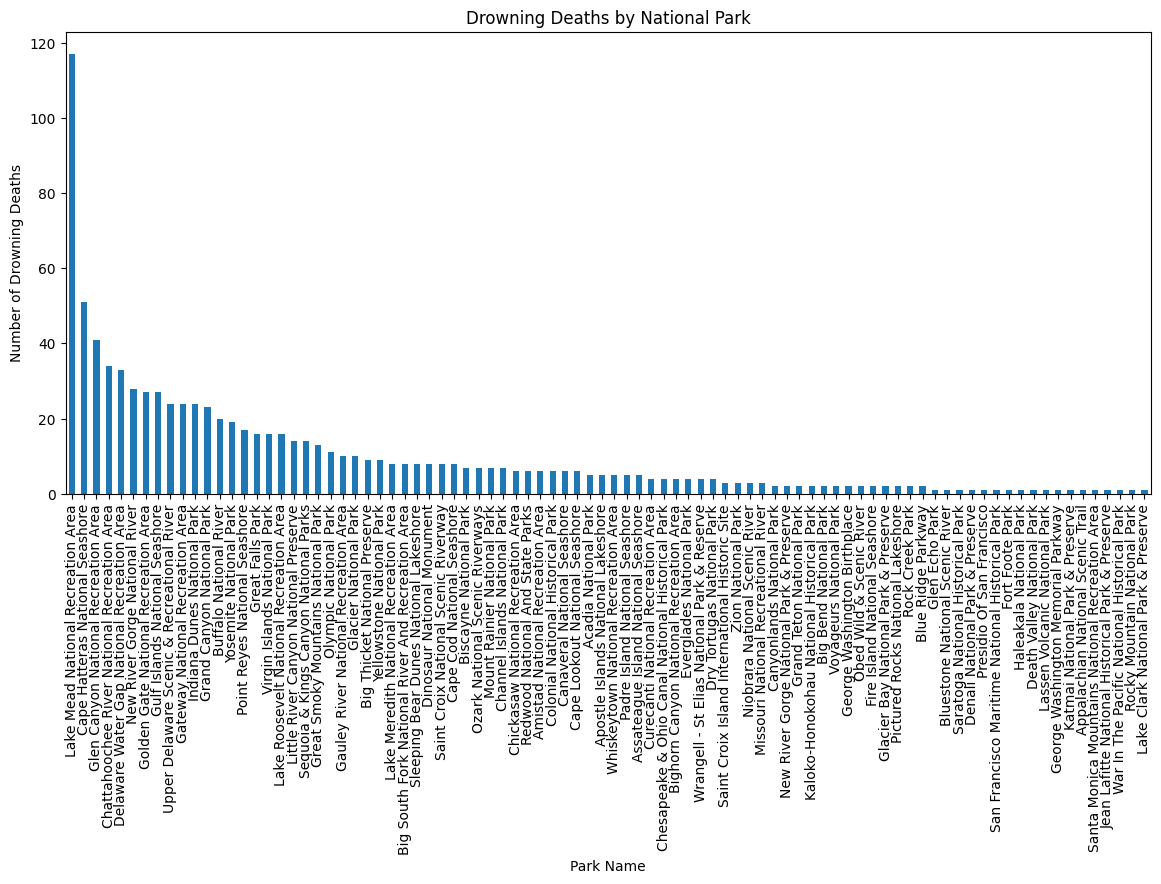

In [955]:
#Filter for drowning
drowning_df = df[df["Cause of Death"] == "Drowning"]

#Count drowning deaths in parks
drowning_counts = drowning_df["Park Name"].value_counts()

#Create bar graph with data
plt.figure(figsize=(14,6))
drowning_counts.plot(kind="bar")

plt.title("Drowning Deaths by National Park")
plt.xlabel("Park Name")
plt.ylabel("Number of Drowning Deaths")
plt.xticks(rotation=90)

plt.show()

It looks like there are some outliers, but you can't really see more than that since there are so many entries. I'm going to create another, neater plot with the top 15 parks.

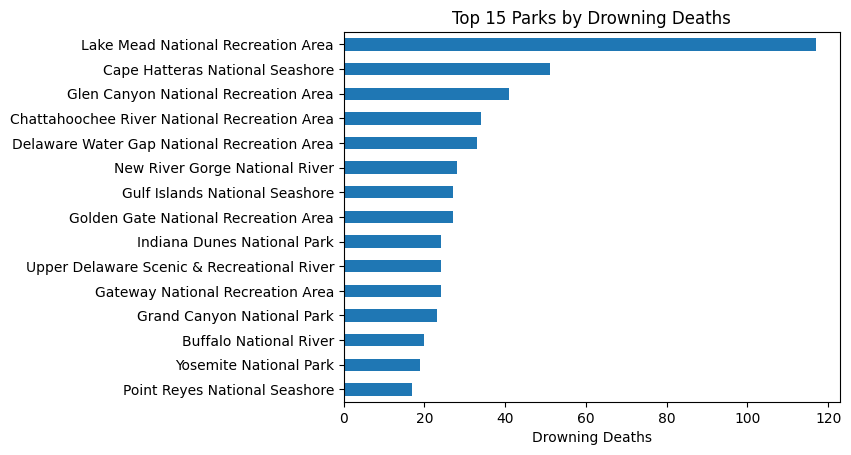

In [956]:
top_drowning = drowning_counts.head(15).sort_values()

top_drowning.plot(kind="barh")
plt.title("Top 15 Parks by Drowning Deaths")
plt.xlabel("Drowning Deaths")
plt.ylabel("")
plt.xticks(rotation=0)
plt.show()

I'm not working with the age range values right now, but I'm going to go ahead and look at those nulls since the rest of the dataset is complete.

In [957]:
print(df["Age Range"].unique())

['65+' 'Not Reported' '15-24' '45-54' '25-34' '55-64' '35-44' '0-14' nan
 '45 - 54' '35 - 44' 'Unintentional' '0 - 14']


So, there's problems. Unintentional, nan, and not reported should all be unknown values. 0 - 14 and 0-14 seem like duplicates. I need to fix the ranges and make as many as possible numeric values. I'm going to start by combining the unknown values and counting them.

In [958]:
unknown_age = {"Not Reported", "Unintentional", "Unknown", None, np.nan}

df["age_range_clean"] = df["Age Range"].replace(list(unknown_age), "Unknown")

print(df["age_range_clean"].value_counts())

age_range_clean
65+        827
55-64      676
Unknown    643
45-54      625
25-34      616
15-24      594
35-44      541
0-14       109
45 - 54      2
35 - 44      1
0 - 14       1
Name: count, dtype: int64


Now I'm going to normalize the spacing to combine the duplicate age ranges. I'm going to normalize the dashes

In [959]:
df["age_range_clean"] = (
    df["age_range_clean"]
    .str.replace(r"\s*-\s*", "-", regex=True)  # normalize dashes
    .str.strip()
)

I'm going to double check that the values combined correctly.

In [960]:
print(df["age_range_clean"].value_counts())

age_range_clean
65+        827
55-64      676
Unknown    643
45-54      627
25-34      616
15-24      594
35-44      542
0-14       110
Name: count, dtype: int64


I may have to revisit 65+, depending on what type of analysis I want to do, but for now I'm going to leave it as is and comvert the numeric ranges into min and max values, and calculate the midpoint. I'll use nan value for the max age in the 65+ column. Being numeric values instead of strings will prepare the data for any by age statistical analysis I may want to do later.

In [961]:
ranges = df["age_range_clean"].str.extract(r"(?P<min>\d+)-(?P<max>\d+)")
df["age_min"] = ranges["min"].astype(float)
df["age_max"] = ranges["max"].astype(float)

mask_plus = df["age_range_clean"].str.endswith("+", na=False)
df.loc[mask_plus, "age_min"] = df.loc[mask_plus, "age_range_clean"].str[:-1].astype(float)
df.loc[mask_plus, "age_max"] = np.nan 

df["age_mid"] = (df["age_min"] + df["age_max"]) / 2

Confirm that the columns have been added as numeric values

In [962]:
df.dtypes

Incident Date                                                    datetime64[ns]
Park Name                                                                object
Cause of Death                                                           object
Cause of Death Group \n(Used in the NPS Mortality Dashboard)             object
Intent                                                                   object
Outcome                                                                  object
Sex                                                                      object
Age Range                                                                object
Activity                                                                 object
age_range_clean                                                          object
age_min                                                                 float64
age_max                                                                 float64
age_mid                                 

One more sanity check -- I want to see the values and make sure that the min/max/mid ages are correct, and the NaN values are as expected.

In [963]:
print(df[["age_range_clean","age_min","age_max","age_mid"]].drop_duplicates())

   age_range_clean  age_min  age_max  age_mid
0              65+     65.0      NaN      NaN
1          Unknown      NaN      NaN      NaN
3            15-24     15.0     24.0     19.5
4            45-54     45.0     54.0     49.5
7            25-34     25.0     34.0     29.5
10           55-64     55.0     64.0     59.5
11           35-44     35.0     44.0     39.5
13            0-14      0.0     14.0      7.0


I know that I want to use data from other NPS datasets along with this information. I also know that there are 3 major sources (NPS Mortality Dataset, IRMA API, and NPS Data API) and the park name is inconsistent across all 3. The API datasets both use a 4 letter code that is  consistent. I'm going to use one of the APIs to match the names of the parks in the mortality dataset to the appropriate park code so that I may query either database for info with the 4 letter code.

BASE = "https://developer.nps.gov/api/v1/parks"
params = {"limit": 50, "start": 0, "api_key": API_KEY}
r = requests.get(BASE, params=params, timeout=30)
print(r.status_code) 

Requesting list of keys for data returned so I can see how to filter for the park code and the full name.

BASE = "https://developer.nps.gov/api/v1/parks"
params = {"limit": 50, "start": 0, "api_key": API_KEY}
r = requests.get(BASE, params=params, timeout=30)
data = r.json()["data"]
if data:
    print(list(data[0].keys()))

I want the "fullName" and "parkCode" for each row. I'm going to craft an API call to build this dataframe.

def fetch_all_parks(api_key: str, page_size: int = 50, pause: float = 0.2) -> pd.DataFrame:
    base = "https://developer.nps.gov/api/v1/parks"
    start = 0
    rows = []

#Create a loop that will continue until there is no data or the data returned is < the page size
    while True:
        params = {"limit": page_size, "start": start, "api_key": api_key}
        resp = requests.get(base, params=params, timeout=30)
        resp.raise_for_status()
        #convert the response from JSON text to Python dictionary
        payload = resp.json()

        data = payload.get("data", [])
        if not data:
            break
        
        #The default parks response has more info than I need, so I'm going to filter just for the name and park code
        for item in data:
            rows.append({
                "fullName": item.get("fullName"),
                "parkCode": item.get("parkCode")
            })

        if len(data) < page_size:
            break

        start += page_size
        time.sleep(pause)

    return pd.DataFrame(rows).drop_duplicates().reset_index(drop=True)

df_parks = fetch_all_parks(API_KEY, page_size=50)
df_parks.head()

Saving the data with park names and park codes to a .csv file

In [964]:
print("Number of parks:", len(df_parks))
df_parks.to_csv("nps_parks_fullName_parkCode.csv", index=False)

Number of parks: 474


Now we'll examine the new dataframe.

In [965]:
df_parks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fullName  474 non-null    object
 1   parkCode  474 non-null    object
dtypes: object(2)
memory usage: 7.5+ KB


In [966]:
df_parks.tail()

,fullName,parkCode
469,Yorktown Battlefield Part of Colonial National...,york
470,Yosemite National Park,yose
471,Yucca House National Monument,yuho
472,Yukon - Charley Rivers National Preserve,yuch
473,Zion National Park,zion


In [967]:
df_parks["fullName"].duplicated().sum()

np.int64(0)

In [968]:
df_parks["parkCode"].duplicated().sum()

np.int64(0)

Now that I have the names and the park codes, I'm going to build a dictionary with the df_parks dataframe that I can use to add the parkCode to our existing dataframe

In [969]:
code_map = dict(zip(df_parks["fullName"], df_parks["parkCode"]))

#Make a copy of the mortality dataframe so we aren't modifying original
df_with_codes = df.copy()

#Add columns for parkCode and Park Name
df_with_codes["parkCode"] = df_with_codes["Park Name"].map(code_map)

#Merge data from df_parks into new columns for exact matches
name_map = dict(zip(df_parks["fullName"], df_parks["fullName"]))
df_with_codes["fullName_official"] = df_with_codes["Park Name"].map(name_map)

#Print info about what was merged, what is missing
total = len(df_with_codes)
matched = df_with_codes["parkCode"].notna().sum()
print(f"Total rows: {total}")
print(f"Matched rows: {matched}")
print(f"Unmatched rows: {total - matched}")

unmatched_names = (
    df_with_codes.loc[df_with_codes["parkCode"].isna(), "Park Name"]
    .dropna()
    .drop_duplicates()
    .sort_values()
)

print("\nUnique unmatched park names:")
for nm in unmatched_names:
    print("-", nm)

Total rows: 4635
Matched rows: 4323
Unmatched rows: 312

Unique unmatched park names:
- Big South Fork National River And Recreation Area
- Canyon De Chelly National Monument
- Castillo De San Marcos National Monument
- George Washington Birthplace
- Haleakala National Park
- Hawaii Volcanoes National Park
- Jean Lafitte National Historical Park & Preserve
- Kaloko-Honokohau National Historical Park
- National Mall & Memorial Parks
- New River Gorge National River
- Not Reported
- President'S Park (White House)
- Presidio Of San Francisco
- Redwood National And State Parks
- Suitland
- Wilson'S Creek National Battlefield
- Wrangell - St Elias National Park & Reserve
- Yorktown Battlefield Part Of Colonial National Historical Park


Since there aren't that many, I'm going to create a manual map to add the park codes using the NPS.gov site as a reference (https://www.nps.gov/articles/000/historic-listing-of-nps-park-codes.htm)

The `manual_crosswalk` table used in this notebook was generated with the assistance of ChatGPT to minimize copy/paste and encoding errors in character-specific strings (e.g., *Haleakalā*, *Hawaiʻi*, *Wrangell–St. Elias*, “&” vs “and”, etc.). This helped prevent merge failures when normalizing park names.

 After generation, I manually verified every entry by comparing each `fullName`/`parkCode` against the official NPS website for accuracy. Any mismatches were corrected in the crosswalk file before use in the analysis.

The resulting file is saved as `parkname_manual_crosswalk.csv` and versioned in the repository. If an NPS unit is renamed or redesignated in the future, the crosswalk should be reviewed and updated accordingly.

In [970]:
manual_crosswalk = pd.DataFrame([
    ("Big South Fork National River And Recreation Area", "Big South Fork National River & Recreation Area", "biso"),
    ("Canyon De Chelly National Monument",                "Canyon de Chelly National Monument",            "cach"),
    ("Castillo De San Marcos National Monument",          "Castillo de San Marcos National Monument",      "casa"),
    ("George Washington Birthplace",                      "George Washington Birthplace National Monument","gewa"),
    ("Haleakala National Park",                           "Haleakalā National Park",                       "hale"),
    ("Hawaii Volcanoes National Park",                    "Hawaiʻi Volcanoes National Park",               "havo"),
    ("Jean Lafitte National Historical Park & Preserve",  "Jean Lafitte National Historical Park and Preserve","jela"),
    ("Kaloko-Honokohau National Historical Park",         "Kaloko-Honokōhau National Historical Park",     "kaho"),
    ("National Mall & Memorial Parks",                    "National Mall and Memorial Parks",              "nama"),
    ("New River Gorge National River",                    "New River Gorge National Park and Preserve",    "neri"),  # redesignated; code remains NERI
    ("Not Reported",                                      "Not Reported",                                  None),
    ("President'S Park (White House)",                    "President's Park (White House)",                "whho"),
    ("Presidio Of San Francisco",                         "Presidio of San Francisco",                     "prsf"),
    ("Redwood National And State Parks",                  "Redwood National and State Parks",              "redw"),
    ("Suitland",                                          "Suitland Parkway (under National Capital Parks–East)", "nace"),  # official unit under NACE
    ("Wilson'S Creek National Battlefield",               "Wilson's Creek National Battlefield",           "wicr"),
    ("Wrangell - St Elias National Park & Reserve",       "Wrangell–St. Elias National Park & Preserve",   "wrst"),
    ("Yorktown Battlefield Part Of Colonial National Historical Park", "Yorktown Battlefield, Colonial National Historical Park", "colo"),  # site rolls up under COLO
], columns=["Park Name", "fullName_manual", "parkCode_manual"])


I'll save the manual_croswalk as a .csv, then continue to use the mask to add codes, and then show anything remaining that is still missing a code.

In [971]:

manual_crosswalk.to_csv("parkname_manual_crosswalk.csv", index=False)

# Build lookups (unique index)
code_lookup = manual_crosswalk.set_index("Park Name")["parkCode_manual"]
name_lookup = manual_crosswalk.set_index("Park Name")["fullName_manual"]

df_with_codes["parkCode"] = df_with_codes["parkCode"].fillna(
    df_with_codes["Park Name"].map(code_lookup)
)

# Now recompute the mask for *currently* missing codes
mask_missing_code = df_with_codes["parkCode"].isna() & df_with_codes["Park Name"].notna()

df_with_codes.loc[mask_missing_code].head()

,Incident Date,Park Name,Cause of Death,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Intent,Outcome,Sex,Age Range,Activity,age_range_clean,age_min,age_max,age_mid,parkCode,fullName_official
3613,2021-03-31,Not Reported,Fall,Fall,Unintentional,Fatal Injury,Male,25-34,Not Reported,25-34,25.0,34.0,29.5,None,NaN
4039,2022-05-22,Not Reported,Undetermined,Undetermined,Undetermined,Fatal Injury,Male,65+,Not Reported,65+,65.0,NaN,NaN,None,NaN
4068,2022-06-19,Not Reported,Suicide,Suicide,Intentional,Fatal Injury,Male,25-34,Suicide,25-34,25.0,34.0,29.5,None,NaN


Sanity check

In [972]:
na_count = df_with_codes["parkCode"].isna().sum()
print(na_count)

3


Looking at the rows that are missing, they are all for unreported park names. This is expected since there can be no park code match. I don't need to do anything with these rows because I'm looking specifically at drowning deaths so the won't be included in my dataset. They may need to be excluded for different types of analysis, though.

Now that I have the codes I'll need to get data from NPS API systems and I've cleaned the rows I will be focusing on, I'm going to save this dataframe as a new .csv.

In [973]:
#df_with_codes.to_csv("df_with_codes.csv", index=False)

Sanity check -- let's look at our new dataframe and see if any more cleaning needs to be done before querying for visitation data.

In [974]:
df_with_codes.dtypes

Incident Date                                                    datetime64[ns]
Park Name                                                                object
Cause of Death                                                           object
Cause of Death Group \n(Used in the NPS Mortality Dashboard)             object
Intent                                                                   object
Outcome                                                                  object
Sex                                                                      object
Age Range                                                                object
Activity                                                                 object
age_range_clean                                                          object
age_min                                                                 float64
age_max                                                                 float64
age_mid                                 

I haven't really loked at the "outcome" column, so we'll look more closely there.

In [975]:
df_with_codes["Outcome"].nunique()

2

In [976]:
df_with_codes["Outcome"].unique()

array(['Fatal injury', 'Fatal Injury'], dtype=object)

In [977]:
df_with_codes["Outcome"].value_counts()

Outcome
Fatal Injury    3284
Fatal injury    1351
Name: count, dtype: int64

This doesn't add anything to our dataset. It seems to be a case mismatch, and we already know that each row is a "Fatal Injury". I'm going to drop the entire column.

In [978]:
df_with_codes.drop("Outcome", axis=1, inplace=True)

In [979]:
df_with_codes.dtypes

Incident Date                                                    datetime64[ns]
Park Name                                                                object
Cause of Death                                                           object
Cause of Death Group \n(Used in the NPS Mortality Dashboard)             object
Intent                                                                   object
Sex                                                                      object
Age Range                                                                object
Activity                                                                 object
age_range_clean                                                          object
age_min                                                                 float64
age_max                                                                 float64
age_mid                                                                 float64
parkCode                                

To keep track of what columns we've cleaned, I'll use this list:

CLEANED
Park Name                                                                
Cause of Death                                                           
_Cause of Death Group \n(Used in the NPS Mortality Dashboard)             
Age Range                                                                
age_range_clean                                                          
age_min                                                                 
age_max                                                                 
age_mid                                                                 
parkCode                                                                 
fullName_official                                                        

TO BE CLEANED
Incident Date                                                    
Intent                                                                  
Sex                                                                      
Activity                                                                 

I'll look at the Incident Date more closely.

In [980]:
df_with_codes["Incident Date"].head()

0   2007-01-01
1   2007-01-22
2   2007-01-22
3   2007-01-29
4   2007-01-29
Name: Incident Date, dtype: datetime64[ns]

These are in correct datetime format and I know there are no missing values, so I'll move on.

To keep track of what columns we've cleaned, I'll use this list:

CLEANED
Park Name                                                                
Cause of Death                                                           
_Cause of Death Group \n(Used in the NPS Mortality Dashboard)             
Age Range                                                                
age_range_clean                                                          
age_min                                                                 
age_max                                                                 
age_mid                                                                 
parkCode                                                                 
fullName_official                                                        
Incident Date 

TO BE CLEANED                                                 
Intent                                                                  
Sex                                                                      
Activity                                                                 

We'll look at the intent column:

In [981]:
df_with_codes["Intent"].head()

0     Undetermined
1    Unintentional
2     Undetermined
3    Unintentional
4    Unintentional
Name: Intent, dtype: object

In [982]:
df_with_codes["Intent"].value_counts()

Intent
Unintentional    2713
Intentional       701
Medical           640
Undetermined      581
Name: count, dtype: int64

I want to see if the "Medical" rows all correspond with the various medical causes of death. I'm going to normalize the Intent and Cause of Death columns and then compare to how many I would expect with the medical categories (3).

In [983]:
df_with_codes["Intent_norm"] = df_with_codes["Intent"].astype(str).str.strip().str.casefold()
df_with_codes["Cause_norm"]  = df_with_codes["Cause of Death"].astype(str).str.strip().str.casefold()

# 1) First, see what causes appear under Intent == "Medical"
medical_causes_found = (
    df_with_codes.loc[df_with_codes["Intent_norm"] == "medical", "Cause_norm"]
      .dropna()
      .unique()
)
print("Causes seen for Intent == Medical:", medical_causes_found)
print("Count:", len(medical_causes_found))

Causes seen for Intent == Medical: ['medical - not during physical activity'
 'medical - during physical activity' 'medical - unknown']
Count: 3


This is what I expected. I'm just going to double check that the number of medical intent fields matches the sum of the three types of medical cause fields.

In [984]:
medical_causes = [
    "Medical - Not During Physical Activity",
    "Medical - During Physical Activity",
    "Medical - Unknown"
]

df_with_codes["Cause of Death"].value_counts().loc[medical_causes]

Cause of Death
Medical - Not During Physical Activity    240
Medical - During Physical Activity        318
Medical - Unknown                          82
Name: count, dtype: int64

There are 640 medical causes, and 640 medical intents, so I believe they corrospond correctly. 

To keep track of what columns we've cleaned, I'll use this list:

CLEANED
Park Name                                                                
Cause of Death                                                           
_Cause of Death Group \n(Used in the NPS Mortality Dashboard)             
Age Range                                                                
age_range_clean                                                          
age_min                                                                 
age_max                                                                 
age_mid                                                                 
parkCode                                                                 
fullName_official                                                        
Incident Date 
Intent  

TO BE CLEANED                                                 
                                                             
Sex                                                                      
Activity                                                                 

We'll look at the Sex column next.

In [985]:
df_with_codes["Sex"].value_counts()

Sex
Male            3484
Female           856
Not Reported     295
Name: count, dtype: int64

These are the values we would expect and there are no missing values. No additional work is necessary.

To keep track of what columns we've cleaned, I'll use this list:

CLEANED
Park Name                                                                
Cause of Death                                                           
_Cause of Death Group \n(Used in the NPS Mortality Dashboard)             
Age Range                                                                
age_range_clean                                                          
age_min                                                                 
age_max                                                                 
age_mid                                                                 
parkCode                                                                 
fullName_official                                                        
Incident Date 
Intent  
Sex

TO BE CLEANED                                                 
                                                                    
Activity                                                                 

Now we'll look more closely at the Activity data.

In [986]:
df_with_codes["Activity"].head()

0      Not Reported
1    Vessel Related
2    Vessel Related
3          Driving 
4          Driving 
Name: Activity, dtype: object

I'm going to look at the number of unique values, normalize, and compare just like I did with the Cause of Death column.

In [987]:
df_with_codes["Activity"].nunique()

42

In [988]:
df_with_codes["Activity"] = df["Activity"].str.strip().str.lower()


In [989]:
df_with_codes["Activity"].nunique()

40

Now I'll add the caps back in.

In [990]:
df_with_codes["Activity"] = df_with_codes["Activity"].str.title()

In [991]:
df_with_codes["Activity"].value_counts()

Activity
Driving                       837
Not Reported                  723
Suicide                       650
Hiking                        502
Swimming                      447
Vessel Related                341
Other                         198
Climbing                      149
Walking                       123
Flying                         78
Illegal Activity               65
Bicycling                      64
Homicide                       51
Sleeping                       46
Fishing                        42
Camping                        42
Snorkeling                     36
Sitting                        31
Photographing                  27
Skiing                         23
Diving (Land)                  23
Wading                         21
Canyoneering                   20
Playing Sports                 20
Diving - Scuba                 15
Base Jumping                    8
Eating                          7
Crossing River                  7
Hunting                         6
Rock 

In [992]:
df_with_codes["Activity"].sort_values().unique()

array(['Base Jumping', 'Bicycling', 'Camping', 'Canyoneering', 'Caving',
       'Climbing', 'Crossing River', 'Diving (Land)', 'Diving - Free',
       'Diving - Scuba', 'Driving', 'Eating', 'Fishing', 'Flying',
       'Hiking', 'Homicide', 'Horseback (Or Mule) Riding', 'Hunting',
       'Illegal Activity', 'Not Reported', 'Other', 'Photographing',
       'Playing Sports', 'Rock Scrambeling', 'Rock Scrambling', 'Sitting',
       'Skateboarding', 'Skiing', 'Sleeping', 'Snorkeling',
       'Snowboarding', 'Snowmobiling', 'Snowshoeing', 'Suicide',
       'Swimming', 'Undetermined', 'Vessel Related', 'Wading', 'Walking',
       'Wildlife Watching'], dtype=object)

I can combine "Rock Scrambeling" and "Rock Scrambling". I considered combining "Not Reported" and "Undetermined, but chose not to at this time because they do convey different information.

In [993]:
df_with_codes["Activity"] = df_with_codes["Activity"].replace(
    "Rock Scrambeling", "Rock Scrambling"
)

In [994]:
df_with_codes["Activity"].sort_values().unique()

array(['Base Jumping', 'Bicycling', 'Camping', 'Canyoneering', 'Caving',
       'Climbing', 'Crossing River', 'Diving (Land)', 'Diving - Free',
       'Diving - Scuba', 'Driving', 'Eating', 'Fishing', 'Flying',
       'Hiking', 'Homicide', 'Horseback (Or Mule) Riding', 'Hunting',
       'Illegal Activity', 'Not Reported', 'Other', 'Photographing',
       'Playing Sports', 'Rock Scrambling', 'Sitting', 'Skateboarding',
       'Skiing', 'Sleeping', 'Snorkeling', 'Snowboarding', 'Snowmobiling',
       'Snowshoeing', 'Suicide', 'Swimming', 'Undetermined',
       'Vessel Related', 'Wading', 'Walking', 'Wildlife Watching'],
      dtype=object)

That's the last "To Be Cleaned" column. I'm going to create a new csv with the cleaned columns.

In [995]:
#df_with_codes.to_csv("df_with_codes_cleaned.csv", index=False)

I'm going to use this API call to obtain the total number of visitations for both recreation and nonrecreation in the month the death occured.

IRMA is looking for case sensitive all caps in the parkCode field, so I'm going to change that before building the API. I do have missing values in this column, so I'm going to 

In [996]:
df_with_codes["parkCode"] = (df_with_codes["parkCode"].str.upper())


In [997]:
df_with_codes["parkCode"].head()

0    GLCA
1    GOGA
2    GOGA
3    NATR
4    NATR
Name: parkCode, dtype: object

I'm going to look at a single row and build an API call to get the information for a single, manual entry. 

In [998]:
df_with_codes.head(1)

,Incident Date,Park Name,Cause of Death,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Intent,Sex,Age Range,Activity,age_range_clean,age_min,age_max,age_mid,parkCode,fullName_official,Intent_norm,Cause_norm
0,2007-01-01,Glen Canyon National Recreation Area,Undetermined,Undetermined,Undetermined,Male,65+,Not Reported,65+,65.0,NaN,NaN,GLCA,Glen Canyon National Recreation Area,undetermined,undetermined


BASE = "https://irmaservices.nps.gov/v3/rest/stats/visitation"
params = {
    "unitCodes": "GLCA",
    "startMonth": 1, "startYear": 2007,
    "endMonth": 1,   "endYear": 2007,
    "format": "json",
}

r = requests.get(BASE, params=params, headers={"Accept": "application/json"}, timeout=30)

Check for 200

In [999]:
print(r.status_code) 

200


I want to see the data that was returned.

In [1000]:
data = r.json()
print(data)

[{'Month': 1, 'NonRecreationVisitors': 74, 'RecreationVisitors': 1777, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 2, 'NonRecreationVisitors': 74, 'RecreationVisitors': 1609, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 3, 'NonRecreationVisitors': 74, 'RecreationVisitors': 3178, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 4, 'NonRecreationVisitors': 74, 'RecreationVisitors': 4424, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 5, 'NonRecreationVisitors': 74, 'RecreationVisitors': 7328, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 6, 'NonRecreationVisitors': 74, 'RecreationVisitors': 7429, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 7, 'NonRecreationVisitors': 74, 'RecreationVisitors': 6238, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 8, 'NonRe

Now that I know how to build the API call, I want to determine the data I need. I want to get the monthly visitation statistics for each park in the mortality dataset, for the duration of the mortality dataset. I can then selectively pull from that dataset as needed for analyisis.

In [1001]:
date_col = "Incident Date"
code_col = "parkCode"

df_with_visits = df_with_codes.copy()

In [1002]:
df_with_visits.head()

,Incident Date,Park Name,Cause of Death,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Intent,Sex,Age Range,Activity,age_range_clean,age_min,age_max,age_mid,parkCode,fullName_official,Intent_norm,Cause_norm
0,2007-01-01,Glen Canyon National Recreation Area,Undetermined,Undetermined,Undetermined,Male,65+,Not Reported,65+,65.0,NaN,NaN,GLCA,Glen Canyon National Recreation Area,undetermined,undetermined
1,2007-01-22,Golden Gate National Recreation Area,Drowning,Drowning,Unintentional,Male,Not Reported,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,Golden Gate National Recreation Area,unintentional,drowning
2,2007-01-22,Golden Gate National Recreation Area,Undetermined,Undetermined,Undetermined,Male,Not Reported,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,Golden Gate National Recreation Area,undetermined,undetermined
3,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Female,15-24,Driving,15-24,15.0,24.0,19.5,NATR,Natchez Trace Parkway,unintentional,motor vehicle crash
4,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Female,45-54,Driving,45-54,45.0,54.0,49.5,NATR,Natchez Trace Parkway,unintentional,motor vehicle crash


In [1003]:
#Create the new dataframe to store this data
df_with_visits = df_with_visits.dropna(subset=["parkCode"])

#Define the chronologically first and last index in the dataset
i_first = df_with_visits[date_col].idxmin()
i_last = df_with_visits[date_col].idxmax()

first_row = df_with_visits.loc[i_first, [date_col, code_col]]
last_row  = df_with_visits.loc[i_last,  [date_col, code_col]]

print("First death:", first_row.to_dict())
print("Last death:",  last_row.to_dict())

First death: {'Incident Date': Timestamp('2007-01-01 00:00:00'), 'parkCode': 'GLCA'}
Last death: {'Incident Date': Timestamp('2024-06-29 00:00:00'), 'parkCode': 'PORE'}


Sanity check -- make sure the missing parkCode values were dropped.

In [1004]:
df_with_visits["Incident Date"].isna().sum()

np.int64(0)

Now that I know the first and last month to collect and have verified the API, I'm going to build an API call that collects the monthly visitation stats for every month 01/2007-06/2024.

BASE = "https://irmaservices.nps.gov/v3/rest/stats/visitation"
params = {
    "unitCodes": "GLCA",
    "startMonth": 1, "startYear": 2007,
    "endMonth": 6,   "endYear": 2024,
    "format": "json",
}

r = requests.get(BASE, params=params, headers={"Accept": "application/json"}, timeout=30)

In [1005]:
data = r.json()
print(data)

[{'Month': 1, 'NonRecreationVisitors': 74, 'RecreationVisitors': 1777, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 2, 'NonRecreationVisitors': 74, 'RecreationVisitors': 1609, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 3, 'NonRecreationVisitors': 74, 'RecreationVisitors': 3178, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 4, 'NonRecreationVisitors': 74, 'RecreationVisitors': 4424, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 5, 'NonRecreationVisitors': 74, 'RecreationVisitors': 7328, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 6, 'NonRecreationVisitors': 74, 'RecreationVisitors': 7429, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 7, 'NonRecreationVisitors': 74, 'RecreationVisitors': 6238, 'UnitCode': 'WHMI', 'UnitName': 'Whitman Mission NHS', 'Year': 2007}, {'Month': 8, 'NonRe

I've got the call to collect the data for an individual park, but I want to collect all the parks in my dataset. 

BASE = "https://irmaservices.nps.gov/v3/rest/stats/visitation"

# 1) get unique park
all_codes = (
    df_with_visits["parkCode"]
    .dropna()
    .astype(str)
    .str.upper()
    .unique()
    .tolist()
)

def chunk_list(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

CODES_PER_CALL = 50

all_results = []

with requests.Session() as s:
    for chunk in chunk_list(all_codes, CODES_PER_CALL):
        params = {
            "unitCodes": ",".join(chunk),
            "startMonth": 1,
            "startYear": 2007,
            "endMonth": 6,
            "endYear": 2024,
            "format": "json",
        }
        r = s.get(BASE, params=params, headers={"Accept": "application/json"}, timeout=30)
        r.raise_for_status()
        data = r.json()
        all_results.extend(data)

visits_df = pd.DataFrame(all_results)


I want to view the first few rows of the new visits dataframe.

In [1006]:
visits_df.head()

,Month,NonRecreationVisitors,RecreationVisitors,UnitCode,UnitName,Year
0,1,600,12415,ACAD,Acadia NP,2007
1,2,600,11068,ACAD,Acadia NP,2007
2,3,600,19220,ACAD,Acadia NP,2007
3,4,600,61775,ACAD,Acadia NP,2007
4,5,7500,132152,ACAD,Acadia NP,2007


In [1007]:
visits_df.shape

(38010, 6)

In [1008]:
visits_df.info

<bound method DataFrame.info of        Month  NonRecreationVisitors  RecreationVisitors UnitCode    UnitName  \
0          1                    600               12415     ACAD   Acadia NP   
1          2                    600               11068     ACAD   Acadia NP   
2          3                    600               19220     ACAD   Acadia NP   
3          4                    600               61775     ACAD   Acadia NP   
4          5                   7500              132152     ACAD   Acadia NP   
...      ...                    ...                 ...      ...         ...   
38005      2                    465                7844     WUPA  Wupatki NM   
38006      3                    558               22213     WUPA  Wupatki NM   
38007      4                    540               24708     WUPA  Wupatki NM   
38008      5                    558               19494     WUPA  Wupatki NM   
38009      6                    540               26731     WUPA  Wupatki NM   

       

I'm going to save this visitation information to a .csv

In [1009]:
visits_df.to_csv("NPS_visitation_data.csv", index=False)

Next, I'll check to see if there are any missing values in any of the fields.

In [1010]:
visits_df.isna().sum()


Month                    0
NonRecreationVisitors    0
RecreationVisitors       0
UnitCode                 0
UnitName                 0
Year                     0
dtype: int64

Nothing is missing, so I'm going to check for completeness. If I received all the data I request, the number of rows for each UnitCode will be the same for each park.

In [1011]:
#count the number of rows for each park code
counts = visits_df["UnitCode"].value_counts()
counts

UnitCode
ACAD    210
APIS    210
BADL    210
BISC    210
BISO    210
       ... 
WAPA    210
MISS    162
SACR    138
PAGR    102
FRST     18
Name: count, Length: 183, dtype: int64

In [1012]:
counts.nunique()

5

There are 5 unique counts for unit codes, so I want to know why I don't have the same for the outliers. I'm going to define the one that is most common to be the expected, and then look for the other values.

In [1013]:
#Define the most common row using mode
expected = counts.mode()[0]

#show anything that doesn't match
mismatch = counts[counts != expected]

#Show the result
mismatch

UnitCode
MISS    162
SACR    138
PAGR    102
FRST     18
Name: count, dtype: int64

I'm going to make sure it wasn't a problem with my call to the api and make another call requesting all the data for just those park units.

BASE = "https://irmaservices.nps.gov/v3/rest/stats/visitation"

list_missing_codes = ["MISS", "SACR", "PAGR", "FRST"]
mismatch_codes = (pd.Series(list_missing_codes)
    .dropna()
    .astype(str)
    .str.upper()
    .unique()
    .tolist()
)

def chunk_list(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

CODES_PER_CALL = 50

mismatch_all_results = []

with requests.Session() as s:
    for chunk in chunk_list(mismatch_codes, CODES_PER_CALL):
        params = {
            "unitCodes": ",".join(chunk),
            "startMonth": 1,
            "startYear": 2007,
            "endMonth": 6,
            "endYear": 2024,
            "format": "json",
        }
        r = s.get(BASE, params=params, headers={"Accept": "application/json"}, timeout=30)
        r.raise_for_status()
        data = r.json()
        mismatch_all_results.extend(data)

new_mismatch_data = pd.DataFrame(mismatch_all_results)

Now that I have the data, I'm going to count the rows for each code like I did before.

In [1014]:
mismatch_counts = new_mismatch_data["UnitCode"].value_counts()
mismatch_counts


UnitCode
MISS    162
SACR    138
PAGR    102
FRST     18
Name: count, dtype: int64

In [1015]:
frst_rows = new_mismatch_data[new_mismatch_data["UnitCode"] == "FRST"]

I want to look at some of the rows to see what we do have. FRST is the park unit with the least rows, so I'll start there.

In [1016]:
frst_rows

,Month,NonRecreationVisitors,RecreationVisitors,UnitCode,UnitName,Year
0,1,7,0,FRST,First State NHP,2023
1,2,7,0,FRST,First State NHP,2023
2,3,9,10567,FRST,First State NHP,2023
3,4,9,11411,FRST,First State NHP,2023
4,5,11,16137,FRST,First State NHP,2023
5,6,12,13007,FRST,First State NHP,2023
6,7,12,16725,FRST,First State NHP,2023
7,8,12,18145,FRST,First State NHP,2023
8,9,12,11638,FRST,First State NHP,2023
9,10,12,26836,FRST,First State NHP,2023


I want to confirm that there really is no data prior to the first month I have, which is 01/2023. I'm going to make one additional API call to see what the earliest record is just to confirm this isn't due to an error in my previous API call to get this info.

BASE = "https://irmaservices.nps.gov/v3/rest/stats/visitation"
params = {
    "unitCodes": "FRST",
    "startYear": 2010,
    "endYear": 2025,
    "format": "json",
}
r = requests.get(BASE, params=params)
data = r.json()

# find earliest record
earliest = min([f"{d['Year']}-{d['Month']:02}" for d in data])
earliest


I've confirmed that this is the earliest data available and I've done a google search to see if there is anything I can find that would explain why the data isn't available. I haven't found anything. 

I'm going to add the visitation data into my cleaned df with codes, so I'm just going to look at the first few rows to refresh my memory on my column names.

In [1017]:
df_with_visits.head()

,Incident Date,Park Name,Cause of Death,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Intent,Sex,Age Range,Activity,age_range_clean,age_min,age_max,age_mid,parkCode,fullName_official,Intent_norm,Cause_norm
0,2007-01-01,Glen Canyon National Recreation Area,Undetermined,Undetermined,Undetermined,Male,65+,Not Reported,65+,65.0,NaN,NaN,GLCA,Glen Canyon National Recreation Area,undetermined,undetermined
1,2007-01-22,Golden Gate National Recreation Area,Drowning,Drowning,Unintentional,Male,Not Reported,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,Golden Gate National Recreation Area,unintentional,drowning
2,2007-01-22,Golden Gate National Recreation Area,Undetermined,Undetermined,Undetermined,Male,Not Reported,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,Golden Gate National Recreation Area,undetermined,undetermined
3,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Female,15-24,Driving,15-24,15.0,24.0,19.5,NATR,Natchez Trace Parkway,unintentional,motor vehicle crash
4,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Female,45-54,Driving,45-54,45.0,54.0,49.5,NATR,Natchez Trace Parkway,unintentional,motor vehicle crash


I see a few things that I can go ahead and clean up before I add the new data. I'm going to get rid of the original Intent and Cause fields and replace them with the normalized data. I'll get rid of the old Age Range Data and rename the cleaned data. I still have them in my orignal dataset if I need to reference the original version, and they're redundant here.

In [1018]:
df_with_visits = df_with_visits.drop(columns=["Age Range", "Intent", "Cause of Death"])

In [1019]:
df_with_visits.head()

,Incident Date,Park Name,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Sex,Activity,age_range_clean,age_min,age_max,age_mid,parkCode,fullName_official,Intent_norm,Cause_norm
0,2007-01-01,Glen Canyon National Recreation Area,Undetermined,Male,Not Reported,65+,65.0,NaN,NaN,GLCA,Glen Canyon National Recreation Area,undetermined,undetermined
1,2007-01-22,Golden Gate National Recreation Area,Drowning,Male,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,Golden Gate National Recreation Area,unintentional,drowning
2,2007-01-22,Golden Gate National Recreation Area,Undetermined,Male,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,Golden Gate National Recreation Area,undetermined,undetermined
3,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Female,Driving,15-24,15.0,24.0,19.5,NATR,Natchez Trace Parkway,unintentional,motor vehicle crash
4,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Female,Driving,45-54,45.0,54.0,49.5,NATR,Natchez Trace Parkway,unintentional,motor vehicle crash


In [1020]:
visits_df.head()

,Month,NonRecreationVisitors,RecreationVisitors,UnitCode,UnitName,Year
0,1,600,12415,ACAD,Acadia NP,2007
1,2,600,11068,ACAD,Acadia NP,2007
2,3,600,19220,ACAD,Acadia NP,2007
3,4,600,61775,ACAD,Acadia NP,2007
4,5,7500,132152,ACAD,Acadia NP,2007


I'm going to pull the month and year out of my Incident Date datetime field so that I can use those as a key to match my visitation data and see if I'm missing data for any of the incidents in my mortality dataset.

In [1021]:
df_with_visits["Month"] = df_with_visits["Incident Date"].dt.month
df_with_visits["Year"]  = df_with_visits["Incident Date"].dt.year
df_with_visits.head()

,Incident Date,Park Name,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Sex,Activity,age_range_clean,age_min,age_max,age_mid,parkCode,fullName_official,Intent_norm,Cause_norm,Month,Year
0,2007-01-01,Glen Canyon National Recreation Area,Undetermined,Male,Not Reported,65+,65.0,NaN,NaN,GLCA,Glen Canyon National Recreation Area,undetermined,undetermined,1,2007
1,2007-01-22,Golden Gate National Recreation Area,Drowning,Male,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,Golden Gate National Recreation Area,unintentional,drowning,1,2007
2,2007-01-22,Golden Gate National Recreation Area,Undetermined,Male,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,Golden Gate National Recreation Area,undetermined,undetermined,1,2007
3,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Female,Driving,15-24,15.0,24.0,19.5,NATR,Natchez Trace Parkway,unintentional,motor vehicle crash,1,2007
4,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Female,Driving,45-54,45.0,54.0,49.5,NATR,Natchez Trace Parkway,unintentional,motor vehicle crash,1,2007


Now I'm going to merge the dataframes

In [1022]:
df_with_visits = df_with_visits.merge(
    visits_df,
    how="left",
    left_on=["parkCode", "Month", "Year"],
    right_on=["UnitCode", "Month", "Year"]
)
df_with_visits

,Incident Date,Park Name,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Sex,Activity,age_range_clean,age_min,age_max,age_mid,parkCode,fullName_official,Intent_norm,Cause_norm,Month,Year,NonRecreationVisitors,RecreationVisitors,UnitCode,UnitName
0,2007-01-01,Glen Canyon National Recreation Area,Undetermined,Male,Not Reported,65+,65.0,NaN,NaN,GLCA,Glen Canyon National Recreation Area,undetermined,undetermined,1,2007,899.0,29707.0,GLCA,Glen Canyon NRA
1,2007-01-22,Golden Gate National Recreation Area,Drowning,Male,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,Golden Gate National Recreation Area,unintentional,drowning,1,2007,0.0,992940.0,GOGA,Golden Gate NRA
2,2007-01-22,Golden Gate National Recreation Area,Undetermined,Male,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,Golden Gate National Recreation Area,undetermined,undetermined,1,2007,0.0,992940.0,GOGA,Golden Gate NRA
3,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Female,Driving,15-24,15.0,24.0,19.5,NATR,Natchez Trace Parkway,unintentional,motor vehicle crash,1,2007,577583.0,486268.0,NATR,Natchez Trace PKWY
4,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Female,Driving,45-54,45.0,54.0,49.5,NATR,Natchez Trace Parkway,unintentional,motor vehicle crash,1,2007,577583.0,486268.0,NATR,Natchez Trace PKWY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4627,2024-06-28,Valley Forge National Historical Park,Motor Vehicle Crash,Not Reported,Driving,65+,65.0,NaN,NaN,VAFO,Valley Forge National Historical Park,unintentional,motor vehicle crash,6,2024,0.0,222324.0,VAFO,Valley Forge NHP
4628,2024-06-28,Delaware Water Gap National Recreation Area,Motor Vehicle Crash,Male,Driving,65+,65.0,NaN,NaN,DEWA,Delaware Water Gap National Recreation Area,unintentional,motor vehicle crash,6,2024,4500.0,386851.0,DEWA,Delaware Water Gap NRA
4629,2024-06-29,Point Reyes National Seashore,Suicide,Not Reported,Suicide,65+,65.0,NaN,NaN,PORE,Point Reyes National Seashore,intentional,suicide,6,2024,2149.0,198096.0,PORE,Point Reyes NS
4630,2024-06-29,Grand Canyon National Park,Undetermined,Male,Hiking,45-54,45.0,54.0,49.5,GRCA,Grand Canyon National Park,undetermined,undetermined,6,2024,2310.0,496170.0,GRCA,Grand Canyon NP


I want to check and see if any of the new columns have missing values. This will tell me if the data that is missing includes any of the incident dates for the mortality dataset. 

In [1023]:
df_with_visits[["NonRecreationVisitors", "RecreationVisitors"]].isna().sum()


NonRecreationVisitors    391
RecreationVisitors       391
dtype: int64

There's quite a bit of missing data, so I need to figure out why.

In [1024]:
missing_visits = df_with_visits[
    df_with_visits["NonRecreationVisitors"].isna() |
    df_with_visits["RecreationVisitors"].isna()
]
missing_visits.head()


,Incident Date,Park Name,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Sex,Activity,age_range_clean,age_min,age_max,age_mid,parkCode,fullName_official,Intent_norm,Cause_norm,Month,Year,NonRecreationVisitors,RecreationVisitors,UnitCode,UnitName
59,2007-06-10,Sequoia & Kings Canyon National Parks,Fall,Male,Climbing,15-24,15.0,24.0,19.5,SEKI,Sequoia & Kings Canyon National Parks,unintentional,fall,6,2007,NaN,NaN,NaN,NaN
79,2007-07-13,National Capital Parks-East,Motor Vehicle Crash,Not Reported,Driving,Unknown,NaN,NaN,NaN,NACE,National Capital Parks-East,unintentional,motor vehicle crash,7,2007,NaN,NaN,NaN,NaN
98,2007-08-21,Sequoia & Kings Canyon National Parks,Fall,Male,Not Reported,35-44,35.0,44.0,39.5,SEKI,Sequoia & Kings Canyon National Parks,unintentional,fall,8,2007,NaN,NaN,NaN,NaN
108,2007-09-12,Glen Echo Park,Drowning,Male,Swimming,55-64,55.0,64.0,59.5,GLEC,Glen Echo Park,unintentional,drowning,9,2007,NaN,NaN,NaN,NaN
137,2007-12-08,Baltimore-Washington Parkway,Motor Vehicle Crash,Not Reported,Driving,Unknown,NaN,NaN,NaN,BAWA,Baltimore-Washington Parkway,unintentional,motor vehicle crash,12,2007,NaN,NaN,NaN,NaN


In [1025]:
missing_visits["parkCode"].nunique()

19

In [1026]:
missing_visits["parkCode"].value_counts()


parkCode
SEKI    92
BAWA    83
NACE    69
NAMA    53
GRFA    28
PRSF    19
ANAC    18
APPA    10
OBED     4
FODU     3
SACR     2
KEAQ     2
FOFO     2
GLEC     1
OXHI     1
PAGR     1
FRST     1
THJE     1
AMME     1
Name: count, dtype: int64

In [1027]:
missing_visits["Park Name"].value_counts()


Park Name
Sequoia & Kings Canyon National Parks             92
Baltimore-Washington Parkway                      83
Suitland                                          56
National Mall & Memorial Parks                    53
Great Falls Park                                  28
Presidio Of San Francisco                         19
Anacostia Park                                    18
National Capital Parks-East                       13
Appalachian National Scenic Trail                 10
Obed Wild & Scenic River                           4
Fort Dupont Park                                   3
Saint Croix Island International Historic Site     2
Kenilworth Park & Aquatic Gardens                  2
Fort Foote Park                                    2
Glen Echo Park                                     1
Oxon Cove Park & Oxon Hill Farm                    1
Paterson Great Falls National Historical Park      1
First State National Historical Park               1
Thomas Jefferson Memorial           

In [1028]:
missing_codes = missing_visits["parkCode"].unique()
missing_codes


array(['SEKI', 'NACE', 'GLEC', 'BAWA', 'GRFA', 'NAMA', 'OXHI', 'APPA',
       'SACR', 'ANAC', 'FOFO', 'PRSF', 'KEAQ', 'PAGR', 'OBED', 'FRST',
       'FODU', 'THJE', 'AMME'], dtype=object)

In [1029]:
codes_in_visits = visits_df["UnitCode"].unique()
codes_with_data = [code for code in missing_codes if code in codes_in_visits]

codes_with_data


['SACR', 'PAGR', 'FRST']

In [1030]:
mismatch_counts

UnitCode
MISS    162
SACR    138
PAGR    102
FRST     18
Name: count, dtype: int64

I'm going to see if I made any errors in my manual crosswalk that could be causing this issue with the park codes. I'm going to create a dataframe with that .csv and see if any of the problematic codes are there.

In [1031]:
crosswalk = pd.read_csv("parkname_manual_crosswalk.csv")
crosswalk.head()


,Park Name,fullName_manual,parkCode_manual
0,Big South Fork National River And Recreation Area,Big South Fork National River & Recreation Area,biso
1,Canyon De Chelly National Monument,Canyon de Chelly National Monument,cach
2,Castillo De San Marcos National Monument,Castillo de San Marcos National Monument,casa
3,George Washington Birthplace,George Washington Birthplace National Monument,gewa
4,Haleakala National Park,Haleakalā National Park,hale


In [1032]:
crosswalk["parkCode_manual"] = crosswalk["parkCode_manual"].str.upper()
crosswalk.head()

,Park Name,fullName_manual,parkCode_manual
0,Big South Fork National River And Recreation Area,Big South Fork National River & Recreation Area,BISO
1,Canyon De Chelly National Monument,Canyon de Chelly National Monument,CACH
2,Castillo De San Marcos National Monument,Castillo de San Marcos National Monument,CASA
3,George Washington Birthplace,George Washington Birthplace National Monument,GEWA
4,Haleakala National Park,Haleakalā National Park,HALE


In [1033]:
matches = crosswalk[crosswalk["parkCode_manual"].isin(mismatch_counts.index)]
matches

,Park Name,fullName_manual,parkCode_manual


In [1034]:
morematches = crosswalk[crosswalk["parkCode_manual"].isin(missing_codes)]
morematches

,Park Name,fullName_manual,parkCode_manual
8,National Mall & Memorial Parks,National Mall and Memorial Parks,NAMA
12,Presidio Of San Francisco,Presidio of San Francisco,PRSF
14,Suitland,Suitland Parkway (under National Capital Parks...,NACE


I found a table that has all the historic codes for sites that may help me find the missing data. I'm going to try to directly download that table of information into Python.

url = "https://www.nps.gov/articles/000/historic-listing-of-nps-park-codes.htm"
tables = pd.read_html(url)
print(len(tables))          # how many tables pandas found
df_codes = tables[0]        # pick the first one
df_codes.head()

It looks like I got the correct data, but the column names should actually be the data in row 0. I'm going to drop that row and reset the index.

In [1035]:
df_codes.columns = df_codes.iloc[0]
df_codes = df_codes.drop(df_codes.index[0])
df_codes = df_codes.reset_index(drop=True)
df_codes.columns = df_codes.columns.str.strip()
df_codes.head()

,Abraham Lincoln National Heritage Area,See MWR
0,Acadia National Park,ACAD
1,"Adams Memorial, District of Columbia",See NCR
2,Adams National Historical Park,ADAM
3,African American Civil War Memorial,AFAM
4,African Burial Ground National Monument,AFBG


In [1036]:
df_codes.shape

(612, 2)

I'm going to combine my missing_coes and mismatch_counts but one is an array so I'll turn them both into lists first.

In [1037]:
missing_codes_list = list(missing_codes)
mismatch_counts_list = list(mismatch_counts.index)

And then combine them

In [1038]:
combined_missing = missing_codes_list + mismatch_counts_list
combined_missing


['SEKI',
 'NACE',
 'GLEC',
 'BAWA',
 'GRFA',
 'NAMA',
 'OXHI',
 'APPA',
 'SACR',
 'ANAC',
 'FOFO',
 'PRSF',
 'KEAQ',
 'PAGR',
 'OBED',
 'FRST',
 'FODU',
 'THJE',
 'AMME',
 'MISS',
 'SACR',
 'PAGR',
 'FRST']

There are duplicates so I'm going to delete them.

In [1039]:
combined_missing = list(set(combined_missing))
combined_missing


['NACE',
 'OXHI',
 'KEAQ',
 'APPA',
 'PAGR',
 'AMME',
 'THJE',
 'FODU',
 'OBED',
 'ANAC',
 'SACR',
 'SEKI',
 'BAWA',
 'PRSF',
 'GRFA',
 'FOFO',
 'NAMA',
 'GLEC',
 'MISS',
 'FRST']

I'm still not really sure why these codes are missing data. I'm going to do an API call for one of them to see if there is ANY visitation data available.

BASE = "https://irmaservices.nps.gov/v3/rest/stats/visitation"
params = {
    "unitCodes": "SACR",
    "startYear": 2010,
    "endYear": 2025,
    "format": "json",
}
r = requests.get(BASE, params=params)
print(r.status_code)


In [1040]:
print(r.text[:500])

[{"Month":1,"NonRecreationVisitors":74,"RecreationVisitors":1777,"UnitCode":"WHMI","UnitName":"Whitman Mission NHS","Year":2007},{"Month":2,"NonRecreationVisitors":74,"RecreationVisitors":1609,"UnitCode":"WHMI","UnitName":"Whitman Mission NHS","Year":2007},{"Month":3,"NonRecreationVisitors":74,"RecreationVisitors":3178,"UnitCode":"WHMI","UnitName":"Whitman Mission NHS","Year":2007},{"Month":4,"NonRecreationVisitors":74,"RecreationVisitors":4424,"UnitCode":"WHMI","UnitName":"Whitman Mission NHS",


BASE = "https://irmaservices.nps.gov/v3/rest/stats/visitation"
params = {
    "unitCodes": "SACR",
    "startYear": 2010,
    "endYear": 2025,
    "format": "json",
}
r = requests.get(BASE, params=params)
data = r.json()

# find earliest record
earliest = min([f"{d['Year']}-{d['Month']:02}" for d in data])
earliest


I've been looking at the data on the NPS website and it seems like the codes used in the visitation stats don't match all the official codes. For example, Kings Canyon National Park shows a code of KICA, which isn't anywhere in my historical table or the official park codes table. To make matches, I'm going to download all the names and codes from the park so that I can find more matches for the parks units.

On the NPS searchable page, I can find a drop down menu with all of the parks and park codes as they are listed in the visitation stats. I cannot find a complete listing and the park code is required to call the API so I can't get it from there. Using the inspect tool, I've found the code for the dropdown list that populates with all the park names and codes. It is pretty lengthy, so I'm going to copy it from the inpsect panel and save it in a new .html file called visit_codes.html

I'm going to read that .html file in my notbook, and look the length and the first 500 characters to make sure it's opening correctly.

In [1041]:
with open("visit_codes.html", "r", encoding="utf-8") as f:
    html = f.read()

print(len(html))
print(html[:500])


88925
<li role="option" unselectable="on" class="x-boundlist-item" tabindex="-1" data-recordindex="0" data-recordid="1" data-boundview="filtercombobox-1012-picker" aria-selected="false">Abraham Lincoln Birthplace NHP (ABLI)</li><li role="option" unselectable="on" class="x-boundlist-item" tabindex="-1" data-recordindex="1" data-recordid="2" data-boundview="filtercombobox-1012-picker" aria-selected="false">Acadia NP (ACAD)</li><li role="option" unselectable="on" class="x-boundlist-item" tabindex="-1" da


Now I'm going to use BeautifulSoup to find all the items in the boundlist that I copied. This should be all my parks. I'm going to look at the length to see if it's working correctly. Each item that has a class="x-boundlist-item" should be an individual park, so I'm going to divide those into a list and see how many there are. I'm expcting just a little over 400, because that's how many national park units I know exist.

In [1042]:
soup = BeautifulSoup(html, "html.parser")

items = soup.find_all("li", class_="x-boundlist-item")
print(len(items))
print(items[0:5])

415
[<li aria-selected="false" class="x-boundlist-item" data-boundview="filtercombobox-1012-picker" data-recordid="1" data-recordindex="0" role="option" tabindex="-1" unselectable="on">Abraham Lincoln Birthplace NHP (ABLI)</li>, <li aria-selected="false" class="x-boundlist-item" data-boundview="filtercombobox-1012-picker" data-recordid="2" data-recordindex="1" role="option" tabindex="-1" unselectable="on">Acadia NP (ACAD)</li>, <li aria-selected="false" class="x-boundlist-item" data-boundview="filtercombobox-1012-picker" data-recordid="3" data-recordindex="2" role="option" tabindex="-1" unselectable="on">Adams NHP (ADAM)</li>, <li aria-selected="false" class="x-boundlist-item" data-boundview="filtercombobox-1012-picker" data-recordid="4" data-recordindex="3" role="option" tabindex="-1" unselectable="on">African Burial Ground NM (AFBG)</li>, <li aria-selected="false" class="x-boundlist-item" data-boundview="filtercombobox-1012-picker" data-recordid="5" data-recordindex="4" role="option"

Now that it's divided into each list item instead of a giant string of code, I'm going to put it into rows.

In [1043]:
#create blank place to hold the rows when they're created
rows = []

#create for loop that will go through all of the boundlist items 
for li in items:
    #get just the text that would display withough the rest of the code
    text = li.get_text(strip=True)   

    #I'm going to use a regular expression to seperate the part in parentheses from the rest
    m = re.match(r"^(.*)\(([^)]+)\)$", text)
    if m:
        name = m.group(1).strip()
        code = m.group(2).strip()
        rows.append({"UnitName": name, "UnitCode": code})
    else:
        # in case some weird row doesn't match that pattern
        rows.append({"UnitName": text, "UnitCode": None})


In [1044]:
len(df_visit_codes)

415

In [1045]:
df_visit_codes = pd.DataFrame(rows)

df_visit_codes.head()



,UnitName,UnitCode
0,Abraham Lincoln Birthplace NHP,ABLI
1,Acadia NP,ACAD
2,Adams NHP,ADAM
3,African Burial Ground NM,AFBG
4,Agate Fossil Beds NM,AGFO


In [1046]:
df_visit_codes.tail(

)

,UnitName,UnitCode
410,Wupatki NM,WUPA
411,Yellowstone NP,YELL
412,Yosemite NP,YOSE
413,Yukon-Charley Rivers NPRES,YUCH
414,Zion NP,ZION


Since my loop indicated that rows missing park codes or in a different format should record visitsParkCode as "None", I'm going to count how many rows have None in that column.

In [1047]:
(df_visit_codes["UnitCode"] == "None").sum()


np.int64(0)

Now that I have this complete listing for the visitor statistics API, I'm going to save it to a new .csv

In [1048]:
df_visit_codes.to_csv("../data/visit_codes.csv", index=False)


I'll use the API to call for all the parks available in the list and obtain all available visitor data, which I will then map to my dataset.

BASE = "https://irmaservices.nps.gov/v3/rest/stats/visitation"

all_codes = (
    df_visit_codes["UnitCode"]
    .dropna()
    .astype(str)
    .str.upper()
    .unique()
    .tolist()
)

def chunk_list(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

CODES_PER_CALL = 50

all_results = []

with requests.Session() as s:
    for chunk in chunk_list(all_codes, CODES_PER_CALL):
        params = {
            "unitCodes": ",".join(chunk),
            "startMonth": 1,
            "startYear": 2007,
            "endMonth": 6,
            "endYear": 2024,
            "format": "json",
        }
        r = s.get(BASE, params=params, headers={"Accept": "application/json"}, timeout=30)
        r.raise_for_status()
        data = r.json()
        all_results.extend(data)

all_visits_df = pd.DataFrame(all_results)


In [1049]:
all_visits_df.head()

,Month,NonRecreationVisitors,RecreationVisitors,UnitCode,UnitName,Year
0,1,0,4960,ABLI,Abraham Lincoln Birthplace NHP,2007
1,2,0,5877,ABLI,Abraham Lincoln Birthplace NHP,2007
2,3,0,9868,ABLI,Abraham Lincoln Birthplace NHP,2007
3,4,0,17900,ABLI,Abraham Lincoln Birthplace NHP,2007
4,5,0,21277,ABLI,Abraham Lincoln Birthplace NHP,2007


In [1050]:
all_visits_df.shape

(78652, 6)

In [1051]:
visits_df.head()

,Month,NonRecreationVisitors,RecreationVisitors,UnitCode,UnitName,Year
0,1,600,12415,ACAD,Acadia NP,2007
1,2,600,11068,ACAD,Acadia NP,2007
2,3,600,19220,ACAD,Acadia NP,2007
3,4,600,61775,ACAD,Acadia NP,2007
4,5,7500,132152,ACAD,Acadia NP,2007


In [1052]:
visits_df.shape

(38010, 6)

The columns are the same. If my new data includes everything in my old data, I should have the same number of duplicate rows as I do rows in visits_df. 

In [1053]:
# merge on all columns to find exact duplicates between dataframes
shared = all_visits_df.merge(visits_df, how="inner")

len(shared)


38010

Since that was what expected, I am going to overwrite the NPS_visitation_data.csv to hold all the data.

In [1054]:
all_visits_df.to_csv("../data/NPS_visitation_data.csv", index=False)


I'm going to add my new visitation unit codes to my mortality dataset so that I can put all the new data in the correct places.

To efficiently determine the best matches for each park, I utilized ChatGPT. I uploaded df_with_visits.csv, as well as visit_codes.csv, and provide my list of parks without matches. I prompted ChatGPT to use information about NPS park structures, historical locations and unit codes, and geographic locations to determin the best match for incidents that didn't have data. That file is uploaded in the data folder as corrected_park_codes.csv. I'm going to use this code to help match my new visitation data.

In [ ]:
df_corrected_park_codes = pd.read_csv("../Data/corrected_park_codes.csv")

df_corrected_park_codes.head()


,Park Name,Queried parkCode,Matched visitsParkName,Matched visitsParkCode,Notes
0,Sequoia & Kings Canyon National Parks,SEKI,Sequoia NP,SEQU,visit_codes has SEQU and KICA separately; SEKI...
1,Baltimore-Washington Parkway,BAWA,National Capital Parks Combined,NACA,No parkway entries; mapped to NCR umbrella.
2,Suitland,NaN,National Capital Parks East,NCPE,Suitland not present; mapped to NCPE.
3,National Mall & Memorial Parks,NaN,National Capital Parks Central,NCPC,Mall not present; mapped to NCPC/NACA.
4,Great Falls Park,GRFA,National Capital Parks Central,NCPC,Great Falls Park not present; mapped to NCPC.


I'm going to change some of the column names that ChatGPT generated to make it easier to utilize this list.

In [1062]:
df_corrected_park_codes = df_corrected_park_codes.rename(
    columns={"Queried parkCode": "parkCode",
             "Matched visitsParkName": "UnitName",
             "Matched visitsParkCode": "UnitCode"})

df_corrected_park_codes.head()

,Park Name,parkCode,UnitName,UnitCode,Notes
0,Sequoia & Kings Canyon National Parks,SEKI,Sequoia NP,SEQU,visit_codes has SEQU and KICA separately; SEKI...
1,Baltimore-Washington Parkway,BAWA,National Capital Parks Combined,NACA,No parkway entries; mapped to NCR umbrella.
2,Suitland,NaN,National Capital Parks East,NCPE,Suitland not present; mapped to NCPE.
3,National Mall & Memorial Parks,NaN,National Capital Parks Central,NCPC,Mall not present; mapped to NCPC/NACA.
4,Great Falls Park,GRFA,National Capital Parks Central,NCPC,Great Falls Park not present; mapped to NCPC.


In [1065]:
df_with_visits.columns

Index(['Incident Date', 'Park Name',
       'Cause of Death Group \n(Used in the NPS Mortality Dashboard) ', 'Sex',
       'Activity', 'age_range_clean', 'age_min', 'age_max', 'age_mid',
       'parkCode', 'fullName_official', 'Intent_norm', 'Cause_norm', 'Month',
       'Year', 'NonRecreationVisitors', 'RecreationVisitors', 'UnitCode',
       'UnitName'],
      dtype='object')

In [1064]:
df_corrected_park_codes.columns

Index(['Park Name', 'parkCode', 'UnitName', 'UnitCode', 'Notes'], dtype='object')

In [ ]:
df_with_visits["UnitCode"].isnull().sum()

np.int64(391)

Now I'm going to merge this info to df_with_visits df.

In [1070]:
# 0) make sure there are no sneaky spaces in the corrected df
#df_corrected_park_codes.columns = df_corrected_park_codes.columns.str.strip()

# 1) now do the merge (this should work now)
df_with_visits = df_with_visits.merge(
    df_corrected_park_codes[["Park Name", "UnitCode", "UnitName"]],
    how="left",
    left_on="fullName_official",
    right_on="Park Name",
    suffixes=("", "_corr")   # new cols from corrected df will be UnitCode_corr, UnitName_corr
)

# 2) fill ONLY where original was NaN, using the corrected ones
df_with_visits["UnitCode"] = df_with_visits["UnitCode"].fillna(df_with_visits["UnitCode_corr"])
df_with_visits["UnitName"] = df_with_visits["UnitName"].fillna(df_with_visits["UnitName_corr"])

# 3) drop helper columns
df_with_visits = df_with_visits.drop(columns=["Park Name", "UnitCode_corr", "UnitName_corr"])

df_with_visits.head()


,Incident Date,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Sex,Activity,age_range_clean,age_min,age_max,age_mid,parkCode,fullName_official,Intent_norm,Cause_norm,Month,Year,NonRecreationVisitors,RecreationVisitors,UnitCode,UnitName
0,2007-01-01,Undetermined,Male,Not Reported,65+,65.0,NaN,NaN,GLCA,Glen Canyon National Recreation Area,undetermined,undetermined,1,2007,899.0,29707.0,GLCA,Glen Canyon NRA
1,2007-01-22,Drowning,Male,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,Golden Gate National Recreation Area,unintentional,drowning,1,2007,0.0,992940.0,GOGA,Golden Gate NRA
2,2007-01-22,Undetermined,Male,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,Golden Gate National Recreation Area,undetermined,undetermined,1,2007,0.0,992940.0,GOGA,Golden Gate NRA
3,2007-01-29,Motor Vehicle Crash,Female,Driving,15-24,15.0,24.0,19.5,NATR,Natchez Trace Parkway,unintentional,motor vehicle crash,1,2007,577583.0,486268.0,NATR,Natchez Trace PKWY
4,2007-01-29,Motor Vehicle Crash,Female,Driving,45-54,45.0,54.0,49.5,NATR,Natchez Trace Parkway,unintentional,motor vehicle crash,1,2007,577583.0,486268.0,NATR,Natchez Trace PKWY


Now I'll rerun my count to confirm codes were added.

In [1071]:
df_with_visits["UnitCode"].isnull().sum()

np.int64(139)

The number decreased so some were added, but I'm still missing rows. I want to look at the unique values and see which parks still aren't complete.

In [1072]:
df_with_visits[df_with_visits["UnitCode"].isnull()]["parkCode"].unique()


array(['NACE', 'NAMA', 'APPA', 'PRSF', 'AMME'], dtype=object)

Now I'm going to check if any of those parkCodes have any rows with a UnitCode, which would indicate that some data was downloade in the prior API call, but not all.

In [ ]:
#Get the parkCodes where UnitCode is null
missing_codes = df_with_visits.loc[df_with_visits["UnitCode"].isnull(), "parkCode"].unique()

#Filter rows where parkCode is one of those, and UnitCode is NOT null
partial_matches = df_with_visits.loc[
    df_with_visits["parkCode"].isin(missing_codes) & df_with_visits["UnitCode"].notnull(),
    ["parkCode", "UnitCode"]
]

#View the unique parkCodes that have both missing and present UnitCodes
partial_matches["parkCode"].unique()


array(['NACE'], dtype=object)

I still have some without matches. I e

Now I'm going to do some housecleaning on my mortality dataset so that I can appropriately merge the new data. I'll start by looking at the header to make sure I'm working in the correct place with the correct fields.

In [ ]:
df_with_visits.head()

,Incident Date,Park Name_x,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Sex,Activity,age_range_clean,age_min,age_max,age_mid,parkCode,...,Intent_norm,Cause_norm,Month,Year,NonRecreationVisitors,RecreationVisitors,UnitCode,UnitName,Park Name_y,Matched visitsParkCode
0,2007-01-01,Glen Canyon National Recreation Area,Undetermined,Male,Not Reported,65+,65.0,NaN,NaN,GLCA,...,undetermined,undetermined,1,2007,899.0,29707.0,GLCA,Glen Canyon NRA,NaN,NaN
1,2007-01-22,Golden Gate National Recreation Area,Drowning,Male,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,...,unintentional,drowning,1,2007,0.0,992940.0,GOGA,Golden Gate NRA,NaN,NaN
2,2007-01-22,Golden Gate National Recreation Area,Undetermined,Male,Vessel Related,Unknown,NaN,NaN,NaN,GOGA,...,undetermined,undetermined,1,2007,0.0,992940.0,GOGA,Golden Gate NRA,NaN,NaN
3,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Female,Driving,15-24,15.0,24.0,19.5,NATR,...,unintentional,motor vehicle crash,1,2007,577583.0,486268.0,NATR,Natchez Trace PKWY,NaN,NaN
4,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Female,Driving,45-54,45.0,54.0,49.5,NATR,...,unintentional,motor vehicle crash,1,2007,577583.0,486268.0,NATR,Natchez Trace PKWY,NaN,NaN


First I'm going to clean up the column names to be clear, concise, and consistent. I'll start by looking at the list of column names.

In [ ]:
#df_with_visits.columns

Index(['date', 'parkName', 'causeGroup', 'Sex', 'Activity', 'ageRange',
       'ageMin', 'ageMax', 'age_mid', 'parkCode', 'officialName', 'intent',
       'cause', 'month', 'year', 'NonRecreationVisitors', 'RecreationVisitors',
       'UnitCode', 'UnitName', 'Park Name', 'Matched visitsParkCode'],
      dtype='object')

df_with_visit_codes = df_with_visit_codes.rename(
    columns={"Incident Date": "date",
             "Park Name_x": "parkName",
             "Cause of Death Group \n(Used in the NPS Mortality Dashboard) ":"causeGroup", 
             "age_range_clean": "ageRange", 
             "age_min": "ageMin", 
             "age_max": "ageMax",
             "fullName_official": "officialName",
              "Intent_norm": "intent", 
              "Cause_norm": "cause",
              "Month": "month",
              "Year": "year", 
              "Park Name_y": "Park Name"}
)



df_with_visit_codes.columns

df_with_visit_codes.head(15)

df_with_visit_codes.isna().sum()